In [ ]:
#importing necassary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score, roc_curve, accuracy_score, classification_report, confusion_matrix

In [ ]:
df = pd.read_csv('/customer_churn.csv')

In [ ]:
print(df.head())

   CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  \
0           1   22  Female      25               14              4   
1           2   41  Female      28               28              7   
2           3   47    Male      27               10              2   
3           4   35    Male       9               12              5   
4           5   53  Female      58               24              9   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0             27             Basic         Monthly          598   
1             13          Standard         Monthly          584   
2             29           Premium          Annual          757   
3             17           Premium       Quarterly          232   
4              2          Standard          Annual          533   

   Last Interaction  Churn  
0                 9      1  
1                20      0  
2                21      0  
3                18      0  
4                18      0  


In [ ]:
print(df.head())

   CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  \
0           1   22  Female      25               14              4   
1           2   41  Female      28               28              7   
2           3   47    Male      27               10              2   
3           4   35    Male       9               12              5   
4           5   53  Female      58               24              9   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0             27             Basic         Monthly          598   
1             13          Standard         Monthly          584   
2             29           Premium          Annual          757   
3             17           Premium       Quarterly          232   
4              2          Standard          Annual          533   

   Last Interaction  Churn  
0                 9      1  
1                20      0  
2                21      0  
3                18      0  
4                18      0  


In [ ]:
print(df.isnull().sum())

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64


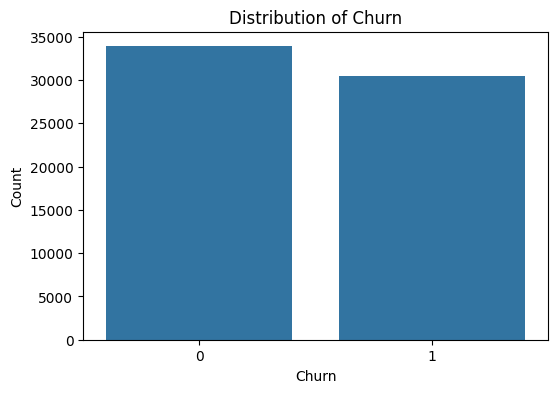

In [ ]:
# 1. Distribution of Churn (Target Variable)
plt.figure(figsize=(6,4))
sns.countplot(x='Churn', data=df)
plt.title('Distribution of Churn')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

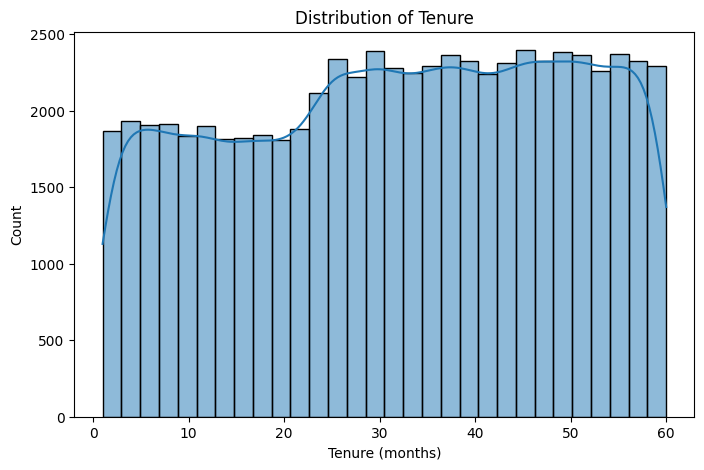

In [ ]:
# 3. Distribution of Tenure (How long customers have been with the company)
plt.figure(figsize=(8,5))
sns.histplot(df['Tenure'], bins=30, kde=True)
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (months)')
plt.ylabel('Count')
plt.show()

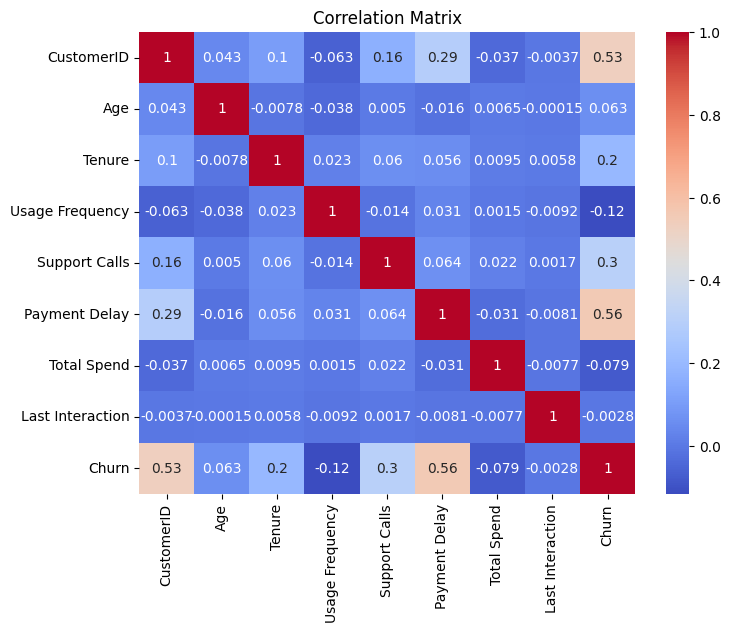

In [ ]:
#correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

In [ ]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "MLP": MLPClassifier(max_iter=500),  # Using MLPClassifier instead of SVM
    "AdaBoost": AdaBoostClassifier()
}

In [ ]:
def calculate_metrics(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)

    # Performance metrics
    metrics = {}
    metrics['MAE'] = mean_absolute_error(y_val, y_pred_val)
    metrics['MSE'] = mean_squared_error(y_val, y_pred_val)
    metrics['RMSE'] = np.sqrt(metrics['MSE'])
    metrics['R² Score'] = r2_score(y_val, y_pred_val)
    metrics['ROC AUC'] = roc_auc_score(y_val, model.predict_proba(X_val)[:, 1])

    return metrics, y_pred_train, y_pred_val

In [ ]:
results_before = {}
for model_name, model in models.items():
    metrics, y_pred_train, y_pred_val = calculate_metrics(model, X_train, X_val, y_train, y_val)
    results_before[model_name] = metrics
    print(f"\nPerformance Metrics for {model_name} (Before Optimization):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")



Performance Metrics for Logistic Regression (Before Optimization):
MAE: 0.1348
MSE: 0.1348
RMSE: 0.3672
R² Score: 0.4590
ROC AUC: 0.9421

Performance Metrics for Random Forest (Before Optimization):
MAE: 0.0034
MSE: 0.0034
RMSE: 0.0585
R² Score: 0.9863
ROC AUC: 1.0000

Performance Metrics for MLP (Before Optimization):
MAE: 0.0176
MSE: 0.0176
RMSE: 0.1328
R² Score: 0.9293
ROC AUC: 0.9987

Performance Metrics for AdaBoost (Before Optimization):
MAE: 0.0712
MSE: 0.0712
RMSE: 0.2669
R² Score: 0.7142
ROC AUC: 0.9828


In [ ]:
param_grid_mlp = {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001, 0.01]}

grids = {
    "Logistic Regression": GridSearchCV(LogisticRegression(max_iter=1000), {'C': [0.1, 1, 10]}, cv=5),
    "Random Forest": GridSearchCV(RandomForestClassifier(), {'n_estimators': [50, 100, 200]}, cv=5),
    "MLP": GridSearchCV(MLPClassifier(max_iter=500), param_grid_mlp, cv=5),  # MLP tuning
    "AdaBoost": GridSearchCV(AdaBoostClassifier(), {'n_estimators': [50, 100, 200]}, cv=5)
}

In [ ]:
results_after = {}
for model_name, grid in grids.items():
    metrics, y_pred_train, y_pred_val = calculate_metrics(grid, X_train, X_val, y_train, y_val)
    results_after[model_name] = metrics
    print(f"\nPerformance Metrics for {model_name} (After Optimization):")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


Performance Metrics for Logistic Regression (After Optimization):
MAE: 0.1348
MSE: 0.1348
RMSE: 0.3672
R² Score: 0.4590
ROC AUC: 0.9421

Performance Metrics for Random Forest (After Optimization):
MAE: 0.0038
MSE: 0.0038
RMSE: 0.0617
R² Score: 0.9847
ROC AUC: 1.0000

Performance Metrics for MLP (After Optimization):
MAE: 0.0099
MSE: 0.0099
RMSE: 0.0997
R² Score: 0.9601
ROC AUC: 0.9996

Performance Metrics for AdaBoost (After Optimization):
MAE: 0.0675
MSE: 0.0675
RMSE: 0.2598
R² Score: 0.7292
ROC AUC: 0.9834


In [ ]:
metrics_df_before = pd.DataFrame(results_before).T
metrics_df_after = pd.DataFrame(results_after).T
print(metrics_df_before)
print(metrics_df_before)

                          MAE       MSE      RMSE  R² Score   ROC AUC
Logistic Regression  0.134835  0.134835  0.367199  0.459010  0.942112
Random Forest        0.003417  0.003417  0.058459  0.986288  0.999985
MLP                  0.017631  0.017631  0.132782  0.929260  0.998734
AdaBoost             0.071223  0.071223  0.266877  0.714235  0.982807
                          MAE       MSE      RMSE  R² Score   ROC AUC
Logistic Regression  0.134835  0.134835  0.367199  0.459010  0.942112
Random Forest        0.003417  0.003417  0.058459  0.986288  0.999985
MLP                  0.017631  0.017631  0.132782  0.929260  0.998734
AdaBoost             0.071223  0.071223  0.266877  0.714235  0.982807


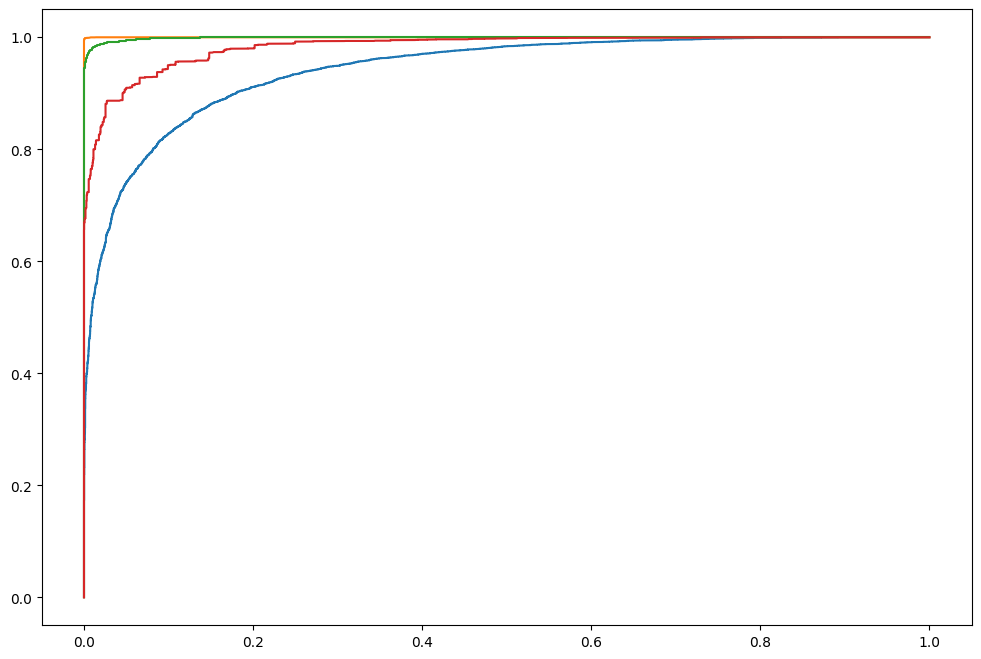

In [ ]:
plt.figure(figsize=(12, 8))
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_val)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc_score(y_val, y_pred_prob):.4f})')


<ipython-input-28-d1e7bb5254b4>:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="lower right")


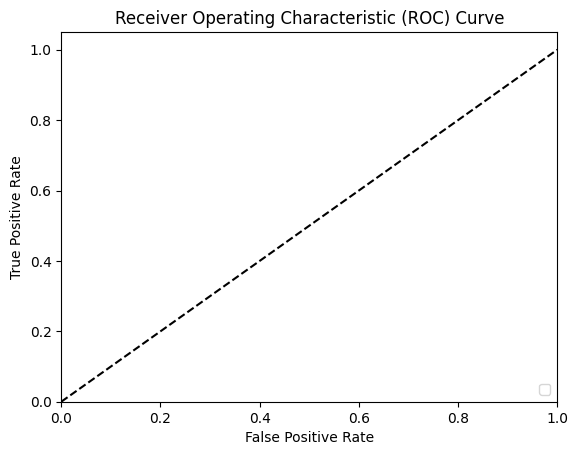

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()